<a href="https://colab.research.google.com/github/galitneu/auto-eda-tool/blob/main/%D7%92%D7%A8%D7%A1%D7%94_%D7%A2%D7%9D_%D7%94%D7%A2%D7%A8%D7%95%D7%AA_%D7%9E%D7%A2%D7%95%D7%93%D7%9B%D7%A0%D7%95%D7%AA_8799.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from google.colab import drive

# ---  הגדרות וטעינת נתונים ---
print("--- שלב 1: טוען נתונים ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/KaggleProject/'

# םתיחת הקבצים לאימון וניבוי
try:
    df_train_raw = pd.read_csv(f'{DRIVE_PATH}Train.csv', low_memory=False, parse_dates=['saledate'])
    df_valid_raw = pd.read_csv(f'{DRIVE_PATH}Valid.csv', low_memory=False, parse_dates=['saledate'])
    print("נתונים נטענו בהצלחה.")
except FileNotFoundError:
    print(f"שגיאה: ודא שהקבצים 'Train.csv' ו-'Valid.csv' נמצאים בתיקייה: {DRIVE_PATH}")
    exit()

# ---  עיבוד נתונים והנדסת מאפיינים ---

# סינון לשנים 2000 ומעלה בגלל שהכלים השתנו במשך השנים ומתחת לשנים האלה זה רעש
df_train_raw = df_train_raw[df_train_raw['saledate'].dt.year >= 2000].copy()
df_valid_raw = df_valid_raw[df_valid_raw['saledate'].dt.year >= 2000].copy()

#תיקונים המחירים לשנת 2012 בגלל אינפלציה
cpi_data_real = {
    2000: 172.2, 2001: 177.1, 2002: 179.9, 2003: 184.0, 2004: 188.9, 2005: 195.3,
    2006: 201.6, 2007: 207.3, 2008: 215.3, 2009: 214.5, 2010: 218.1, 2011: 224.9, 2012: 229.6
}
ADJUSTMENT_YEAR = 2012
inflation_multiplier = {year: cpi_data_real[ADJUSTMENT_YEAR] / cpi for year, cpi in cpi_data_real.items()}

#יצירת עמודה של מחירים מתוקנים
df_train_raw['SalePrice_adj'] = df_train_raw.apply(lambda row: row['SalePrice'] * inflation_multiplier.get(row['saledate'].year, 1), axis=1)
train_original_prices = df_train_raw[['SalePrice', 'SalePrice_adj']].copy()

#יצירת עמודה מבדילה בין בנתונים לפני חיבור שלהם יחד
df_train_raw['source'] = 'train'
df_valid_raw['source'] = 'valid'
df_combined_temp = pd.concat([df_train_raw.drop(['SalePrice', 'SalePrice_adj'], axis=1), df_valid_raw], ignore_index=True)

#חיפוש אחר תאריך הקטן ביותר כדי למצוא את מספר הימים שעברו עבר כל  מכירה
min_date = df_combined_temp['saledate'].min()
#פיצול תאריך המכירה לחלקים חשובים כמו שנה, חודש, יום בתוך השנה, ויום מאז המכירה הישנה ביותר
for df in [df_combined_temp]:
    df['saleYear'] = df['saledate'].dt.year
    df['saleMonth'] = df['saledate'].dt.month
    df['DayOfYear'] = df['saledate'].dt.dayofyear
    df['DaysFromStart'] = (df['saledate'] - min_date).dt.days

#פיצול לשני דאטאסטים של אימון וניבוי
df_train_raw = df_combined_temp[df_combined_temp['source'] == 'train'].drop('source', axis=1).copy()
df_valid_raw = df_combined_temp[df_combined_temp['source'] == 'valid'].drop('source', axis=1).copy()
df_train_raw = pd.concat([df_train_raw.reset_index(drop=True), train_original_prices.reset_index(drop=True)], axis=1)

# 2.2 חישוב מגמה ושאריות עם שני מודלים עונתיים
#פיצול הנתונים של האימון לחודשים ינואר-אפריל וכל השאר
early_season_train_df = df_train_raw[df_train_raw['saleMonth'].isin([1, 2, 3, 4])].copy()
rest_of_year_train_df = df_train_raw[~df_train_raw['saleMonth'].isin([1, 2, 3, 4])].copy()

#יצירת מודל רגרסיה לכל אחד מחלקי האימון
trend_model_early = LinearRegression()
trend_model_early.fit(early_season_train_df[['DaysFromStart']], early_season_train_df['SalePrice_adj'])
trend_model_rest = LinearRegression()
trend_model_rest.fit(rest_of_year_train_df[['DaysFromStart']], rest_of_year_train_df['SalePrice_adj'])

#הגדרת פונצירה עבור חישוב המחיר שהיה אמור להיות על פי הרגרסיה
def predict_seasonal_trend(df):
    early_mask = df['saleMonth'].isin([1, 2, 3, 4])
    predictions = pd.Series(index=df.index, dtype=float)
    if early_mask.sum() > 0:
        predictions.loc[early_mask] = trend_model_early.predict(df.loc[early_mask, ['DaysFromStart']])
    if (~early_mask).sum() > 0:
        predictions.loc[~early_mask] = trend_model_rest.predict(df.loc[~early_mask, ['DaysFromStart']])
    return predictions

#עבור כל שורה - חישוב המחיר שהיה אמור להיות
df_train_raw['SalePrice_Trend'] = predict_seasonal_trend(df_train_raw)
df_valid_raw['SalePrice_Trend'] = predict_seasonal_trend(df_valid_raw)
#חישוב הפער שבין המחיר שהיה אעמור להיות לבין המחיר בפועל כדי שעליו יתאמן המודל. זה רק עבור שנים 2000-2010
df_train_raw['SalePrice_Residual'] = df_train_raw['SalePrice_adj'] - df_train_raw['SalePrice_Trend']

#  איחוד לעיבוד סופי
train_labels_residual = df_train_raw['SalePrice_Residual'].copy()
df_train_proc = df_train_raw.drop(['SalePrice', 'SalePrice_adj', 'SalePrice_Trend', 'SalePrice_Residual', 'saledate', 'SalesID', 'MachineID'], axis=1)
df_train_proc['source'] = 'train'
df_valid_proc = df_valid_raw.drop(['SalePrice_Trend', 'saledate', 'SalesID', 'MachineID'], axis=1)
df_valid_proc['source'] = 'valid'
df_combined = pd.concat([df_train_proc, df_valid_proc], ignore_index=True, sort=False)

# ---  הנדסת מאפיינים ועיבוד נתונים מאוחד  ---

#הרמת דגל עבור שדות של שנת יצור לא תקינים
df_combined['is_YearMade_1000'] = (df_combined['YearMade'] == 1000).astype(int)

# תיקון לשדות של שנת יצור שהם 1000
year_made_by_model = df_combined.groupby('fiModelDesc')['YearMade'].median().astype(int)
rows_to_fix_idx = df_combined[df_combined['YearMade'] == 1000].index
#בכנסת גיל חציוני של המודל הספציפי
imputed_years = df_combined.loc[rows_to_fix_idx, 'fiModelDesc'].map(year_made_by_model)
global_median_year = df_combined.loc[df_combined['YearMade'] != 1000, 'YearMade'].median()
#הכנסת
imputed_years = imputed_years.fillna(global_median_year)
df_combined.loc[rows_to_fix_idx, 'YearMade'] = imputed_years.values
#חישוב גיל המכונה במכירה
df_combined['machineAge'] = df_combined['saleYear'] - df_combined['YearMade']

#הרמת דגל לעמודת שעות עבודה לא תקנית
df_combined['MachineHoursCurrentMeter_is_missing'] = df_combined['MachineHoursCurrentMeter'].isnull() | (df_combined['MachineHoursCurrentMeter'] == 0)
df_combined['MachineHoursCurrentMeter'].replace(0, np.nan, inplace=True)
#חישוב חציון של שעות עבודה למודל הספציפי
imputed_hours = df_combined.groupby('fiModelDesc')['MachineHoursCurrentMeter'].transform(lambda x: x.fillna(x.median()))
df_combined['MachineHoursCurrentMeter'] = imputed_hours
if df_combined['MachineHoursCurrentMeter'].isnull().sum() > 0:
    df_combined['MachineHoursCurrentMeter'].fillna(df_combined['MachineHoursCurrentMeter'].median(), inplace=True)

# טיפול ב-auctioneerID אן ריק אז מקבל  חציון
if df_combined['auctioneerID'].isnull().sum() > 0:
    df_combined['auctioneerID_is_missing'] = df_combined['auctioneerID'].isnull()
    df_combined['auctioneerID'] = df_combined['auctioneerID'].fillna(df_combined['auctioneerID'].median())

# --- הוספת מאפייני Ripper ו-Enclosure
df_combined['Ripper_is_missing'] = df_combined['Ripper'].isnull().astype(int)
ripper_types = ['Yes', 'Multi Shank', 'Single Shank']
df_combined['has_Ripper'] = df_combined['Ripper'].isin(ripper_types).astype(int)
enclosure_mode = df_combined['Enclosure'].mode()[0]
df_combined['Enclosure_Type'] = df_combined['Enclosure'].fillna(enclosure_mode).astype('category').cat.codes
df_combined.drop(['Ripper', 'Enclosure'], axis=1, inplace=True)


df_combined['fiProductClassDesc'] = df_combined['fiProductClassDesc'].fillna('')
keywords_to_extract = ['excavator', 'dozer', 'loader', 'crawler', 'wheel', 'track']
for keyword in keywords_to_extract:
    df_combined[f'is_{keyword}'] = df_combined['fiProductClassDesc'].str.contains(keyword, case=False).astype(int)
df_combined['is_Hours_Zero'] = (df_combined['MachineHoursCurrentMeter'] == 0).astype(int)
df_combined['is_ProductGroup_5'] = (df_combined['ProductGroup'] == 5).astype(int)
df_combined['is_ProductGroup_2'] = (df_combined['ProductGroup'] == 2).astype(int)


# המרת שאר עמודות הטקסט לקודים מספריים
source_col = df_combined['source']
df_combined = df_combined.drop('source', axis=1)
for col_name in df_combined.columns:
    if pd.api.types.is_object_dtype(df_combined[col_name]):
        df_combined[col_name] = df_combined[col_name].fillna('missing').astype('category').cat.codes
df_combined['source'] = source_col

print("\n" + "="*50)
print("---  הערכת ביצועים על סט וולידציה עונתי (ינואר-אפריל 2011) ---")

#  הכנת הנתונים לפיצול
df_train_processed = df_combined[df_combined['source'] == 'train'].drop('source', axis=1).copy()
df_train_processed['SalePrice_Residual'] = train_labels_residual.values
df_train_processed['SalePrice_adj'] = df_train_raw['SalePrice_adj'].values
df_train_processed['saledate'] = df_train_raw['saledate']

#  פיצול עונתי
train_time_split = df_train_processed[df_train_processed['saledate'] < '2011-01-01'].copy()
validation_mask = (df_train_processed['saledate'] >= '2011-01-01') & (df_train_processed['saledate'] < '2011-05-01')
#יצירת נתוני הוולידציה רק על ינואר-אפריל 2011
val_time_split = df_train_processed[validation_mask].copy()


X_train_time = train_time_split.drop(['SalePrice_Residual', 'SalePrice_adj', 'saledate'], axis=1)
y_train_time_residual = train_time_split['SalePrice_Residual']
X_val_time = val_time_split.drop(['SalePrice_Residual', 'SalePrice_adj', 'saledate'], axis=1)
y_val_actual_price = val_time_split['SalePrice_adj']
val_time_trend = df_train_raw.loc[val_time_split.index, 'SalePrice_Trend'].values

#target coding
#חישוב מחיר חציוני למחיר למדינה בלי זליגת מידע
median_price_by_state = train_time_split.groupby('state')['SalePrice_adj'].median()
X_train_time['State_Median_Price'] = X_train_time['state'].map(median_price_by_state)
X_val_time['State_Median_Price'] = X_val_time['state'].map(median_price_by_state)
global_median_price = train_time_split['SalePrice_adj'].median()
X_train_time['State_Median_Price'].fillna(global_median_price, inplace=True)
X_val_time['State_Median_Price'].fillna(global_median_price, inplace=True)

#חישוב מחיר חציוני לנמחיר למודל ולמוכר בלי זליגת מידע
fimodel_median_price = train_time_split.groupby('fiModelDesc')['SalePrice_adj'].median()
auctioneer_median_price = train_time_split.groupby('auctioneerID')['SalePrice_adj'].median()


X_train_time['fiModelDesc_target_encoded'] = X_train_time['fiModelDesc'].map(fimodel_median_price).fillna(global_median_price)
X_train_time['auctioneerID_target_encoded'] = X_train_time['auctioneerID'].map(auctioneer_median_price).fillna(global_median_price)

X_val_time['fiModelDesc_target_encoded'] = X_val_time['fiModelDesc'].map(fimodel_median_price).fillna(global_median_price)
X_val_time['auctioneerID_target_encoded'] = X_val_time['auctioneerID'].map(auctioneer_median_price).fillna(global_median_price)



X_val_time = X_val_time[X_train_time.columns]

# 3.4 אימון מודל וולידציה
print("\nמאמן מודל וולידציה (על נתוני 2000-2010)...")

#פרמטרים האידיאליים שנמצאו בחיפוש
user_params = {
    'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 4,
    'min_samples_leaf': 1, 'max_features': 'sqrt', 'n_jobs': -1, 'random_state': 42
}


validation_model = RandomForestRegressor(**user_params)
validation_model.fit(X_train_time, y_train_time_residual)

#  חיזוי וחישוב ציוני טעות
initial_val_preds_residual = validation_model.predict(X_val_time)
initial_val_preds_full_price = val_time_trend + initial_val_preds_residual

def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
def rmsle(y_true, y_pred): return np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 1)))

final_val_rmse = rmse(y_val_actual_price, initial_val_preds_full_price)
final_val_rmsle = rmsle(y_val_actual_price, initial_val_preds_full_price)

print("\n--- ביצועי המודל על סט הוולידציה העונתי ---")
print(f"סט וולידציה (Validation Set - ינואר-אפריל 2011):")
print(f"\tRMSE:  ${final_val_rmse:,.2f}")
print(f"\tRMSLE: {final_val_rmsle:.4f}\n")


# ---  אימון מודל סופי  ---
#המודל הזה כולל גם את 2011
print("\n" + "="*50)
print("---  מאמן מודל סופי עם הפרמטרים ---")

# 4.1 הכנת הנתונים הסופיים לאימון
X_full_train = df_train_processed.drop(['SalePrice_Residual', 'SalePrice_adj', 'saledate'], axis=1)
y_full_train_residual = df_train_processed['SalePrice_Residual']
df_valid_processed = df_combined[df_combined['source'] == 'valid'].drop('source', axis=1).copy()
df_valid_processed_aligned = df_valid_processed[X_full_train.columns]

# 4.2 Target Encoding לכל סט האימון ולסט המבחן
# חשוב: נשתמש באותו median_price_by_state שחושב על נתוני 2000-2010
X_full_train['State_Median_Price'] = X_full_train['state'].map(median_price_by_state)
X_full_train['State_Median_Price'].fillna(global_median_price, inplace=True)

df_valid_processed_aligned['State_Median_Price'] = df_valid_processed_aligned['state'].map(median_price_by_state)
df_valid_processed_aligned['State_Median_Price'].fillna(global_median_price, inplace=True)

df_valid_processed_aligned = df_valid_processed_aligned[X_full_train.columns]


X_full_train['fiModelDesc_target_encoded'] = X_full_train['fiModelDesc'].map(fimodel_median_price).fillna(global_median_price)
X_full_train['auctioneerID_target_encoded'] = X_full_train['auctioneerID'].map(auctioneer_median_price).fillna(global_median_price)

df_valid_processed_aligned['fiModelDesc_target_encoded'] = df_valid_processed_aligned['fiModelDesc'].map(fimodel_median_price).fillna(global_median_price)
df_valid_processed_aligned['auctioneerID_target_encoded'] = df_valid_processed_aligned['auctioneerID'].map(auctioneer_median_price).fillna(global_median_price)

# 4.3 אימון המודל הסופי
final_model = RandomForestRegressor(**user_params)
final_model.fit(X_full_train, y_full_train_residual)
print("אימון המודל הסופי הושלם!")

# --- שלב 5: יצירת קובץ הגשה סופי ---

final_residuals_pred = final_model.predict(df_valid_processed_aligned)
final_trend_values = df_valid_raw['SalePrice_Trend'].values
#המודל מחזיר שאלית ולכן צריך להפוך חזרה למחיר על פי מודל הרגרסיה
final_price_pred = final_trend_values + final_residuals_pred
final_price_pred_floored = np.maximum(final_price_pred, 1000)

df_submission = pd.DataFrame({'SalesID': df_valid_raw['SalesID'], 'SalePrice': final_price_pred_floored})
submission_filename = f'{DRIVE_PATH}submission_Final_Winning_Model_v4.csv'
df_submission.to_csv(submission_filename, index=False)

print(f"\nקובץ ההגשה '{submission_filename}' נשמר בהצלחה!")
print("5 השורות הראשונות בקובץ ההגשה:")
print(df_submission.head())

--- שלב 1: טוען נתונים ---
Mounted at /content/drive
נתונים נטענו בהצלחה.


/tmp/ipython-input-3413534378.py:113: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combined['MachineHoursCurrentMeter'].replace(0, np.nan, inplace=True)
/tmp/ipython-input-3413534378.py:118: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(v


---  הערכת ביצועים על סט וולידציה עונתי (ינואר-אפריל 2011) ---


/tmp/ipython-input-3413534378.py:181: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_time['State_Median_Price'].fillna(global_median_price, inplace=True)
/tmp/ipython-input-3413534378.py:182: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth


מאמן מודל וולידציה (על נתוני 2000-2010)...

--- ביצועי המודל על סט הוולידציה העונתי ---
סט וולידציה (Validation Set - ינואר-אפריל 2011):
	RMSE:  $8,615.60
	RMSLE: 0.2200


---  מאמן מודל סופי עם הפרמטרים ---


/tmp/ipython-input-3413534378.py:242: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_full_train['State_Median_Price'].fillna(global_median_price, inplace=True)
/tmp/ipython-input-3413534378.py:245: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

אימון המודל הסופי הושלם!

קובץ ההגשה '/content/drive/MyDrive/KaggleProject/submission_Final_Winning_Model_v4.csv' נשמר בהצלחה!
5 השורות הראשונות בקובץ ההגשה:
        SalesID     SalePrice
313947  1222837  59632.413763
313948  1222839  81896.823806
313949  1222841  32690.091197
313950  1222843  15996.090448
313951  1222845  37936.024340


In [2]:
# --- שלב 3.6: חישוב Permutation Importance ---
print("\n" + "-"*20 + " מחשב Permutation Importance (בצורה הנכונה) " + "-"*20)

from sklearn.inspection import permutation_importance

# פונצקיה לחישוב השגיאה על המחיר המלא
def custom_rmsle_scorer(model, X, y_true):
    """
    Scorer מותאם אישית שמחשב את ה-RMSLE על המחיר המלא.
    """
    # חיזו של השארית על ידי המודל
    residuals_pred = model.predict(X)

    # יציתר המחיר המלא
    full_price_pred = val_time_trend + residuals_pred

    # חישוב שגיאה
    full_price_pred_positive = np.maximum(full_price_pred, 1)

    # לערך  גבוה יותר = טוב יותר
    return -rmsle(y_true, full_price_pred_positive)

result = permutation_importance(
    validation_model,
    X_val_time,
    y_val_actual_price,
    n_repeats=10,
    random_state=42,
    n_jobs=1,
    scoring=custom_rmsle_scorer
)

perm_importance_df = pd.DataFrame({
    'feature': X_val_time.columns,
    'importance_mean': result.importances_mean,
}).sort_values('importance_mean', ascending=False)

print("\n--- Top 20 Features (הכי חשובים) לפי Permutation Importance ---")
print(perm_importance_df.head(20).to_string(index=False))

print("\n--- Bottom 10 Features (הכי פחות חשובים או מזיקים) ---")
print(perm_importance_df.tail(10).to_string(index=False))

# זיהוי פיצ'רים עם חשיבות שלילית (כאלה שכנראה מזיקים למודל)
harmful_features = perm_importance_df[perm_importance_df['importance_mean'] < 0]
if not harmful_features.empty:
    print("\n פיצ'רים עם חשיבות שלילית (מומלץ לשקול להסיר אותם):")
    print(harmful_features.to_string(index=False))
else:
    print("\n לא נמצאו פיצ'רים עם חשיבות שלילית מובהקת.")


-------------------- מחשב Permutation Importance (בצורה הנכונה) --------------------

--- Top 20 Features (הכי חשובים) לפי Permutation Importance ---
                   feature  importance_mean
fiModelDesc_target_encoded         0.264509
                machineAge         0.078799
               ProductSize         0.062503
                  YearMade         0.053363
            Enclosure_Type         0.025565
        fiProductClassDesc         0.019299
            Coupler_System         0.017609
  MachineHoursCurrentMeter         0.012631
         fiModelDescriptor         0.012038
                   ModelID         0.011445
               fiModelDesc         0.011245
           fiSecondaryDesc         0.008868
               fiBaseModel         0.008173
          ProductGroupDesc         0.006931
              ProductGroup         0.005664
            Grouser_Tracks         0.005493
                Hydraulics         0.004255
         Ripper_is_missing         0.003985
             

In [4]:
df_train_trunc = df_train_raw[df_train_raw['saledate'].dt.year >= 2000]


מקדמי תיקון אינפלציה:
  2000: x1.333
  2001: x1.296
  2002: x1.276
  2003: x1.248
  2004: x1.215
  2005: x1.176
  2006: x1.139
  2007: x1.108
  2008: x1.066
  2009: x1.070
  2010: x1.053
  2011: x1.021
  2012: x1.000


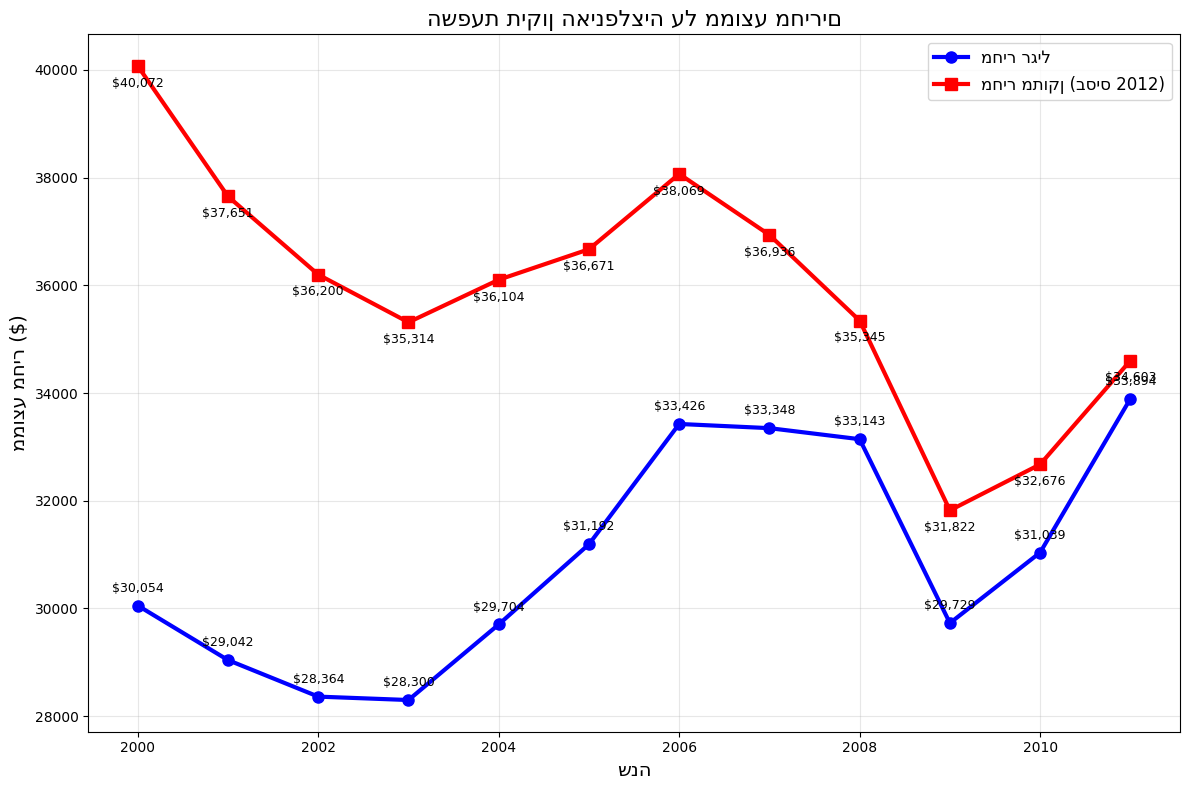

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. נתוני CPI (מדד המחירים לצרכן)
cpi_data_real = {
    2000: 172.2, 2001: 177.1, 2002: 179.9, 2003: 184.0, 2004: 188.9, 2005: 195.3,
    2006: 201.6, 2007: 207.3, 2008: 215.3, 2009: 214.5, 2010: 218.1, 2011: 224.9, 2012: 229.6
}

#  חישוב מקדמי התיקון (בסיס שנת 2012)
ADJUSTMENT_YEAR = 2012
inflation_multiplier = {year: cpi_data_real[ADJUSTMENT_YEAR] / cpi
                       for year, cpi in cpi_data_real.items()}


#  יצירת עמודת שנה (אם עדיין לא קיימת)
df_train_trunc['year'] = df_train_trunc['saledate'].dt.year

#  חישוב מחיר מתוקן
df_train_trunc['SalePrice_adj'] = df_train_trunc.apply(
    lambda row: row['SalePrice'] * inflation_multiplier.get(row['year'], 1),
    axis=1
)

#  חישוב ממוצעים לפי שנה
yearly_avg_original = df_train_trunc.groupby('year')['SalePrice'].mean()
yearly_avg_adjusted = df_train_trunc.groupby('year')['SalePrice_adj'].mean()

plt.figure(figsize=(12, 8))

plt.plot(yearly_avg_original.index, yearly_avg_original.values,
         marker='o', linewidth=3, markersize=8, label='מחיר רגיל', color='blue')
plt.plot(yearly_avg_adjusted.index, yearly_avg_adjusted.values,
         marker='s', linewidth=3, markersize=8, label='מחיר מתוקן (בסיס 2012)', color='red')

plt.title('השפעת תיקון האינפלציה על ממוצע מחירים', fontsize=16)
plt.xlabel('שנה', fontsize=14)
plt.ylabel('ממוצע מחיר ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# הוספת ערכים על הגרף
for year in yearly_avg_original.index:
    plt.annotate(f'${yearly_avg_original[year]:,.0f}',
                (year, yearly_avg_original[year]),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    plt.annotate(f'${yearly_avg_adjusted[year]:,.0f}',
                (year, yearly_avg_adjusted[year]),
                textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


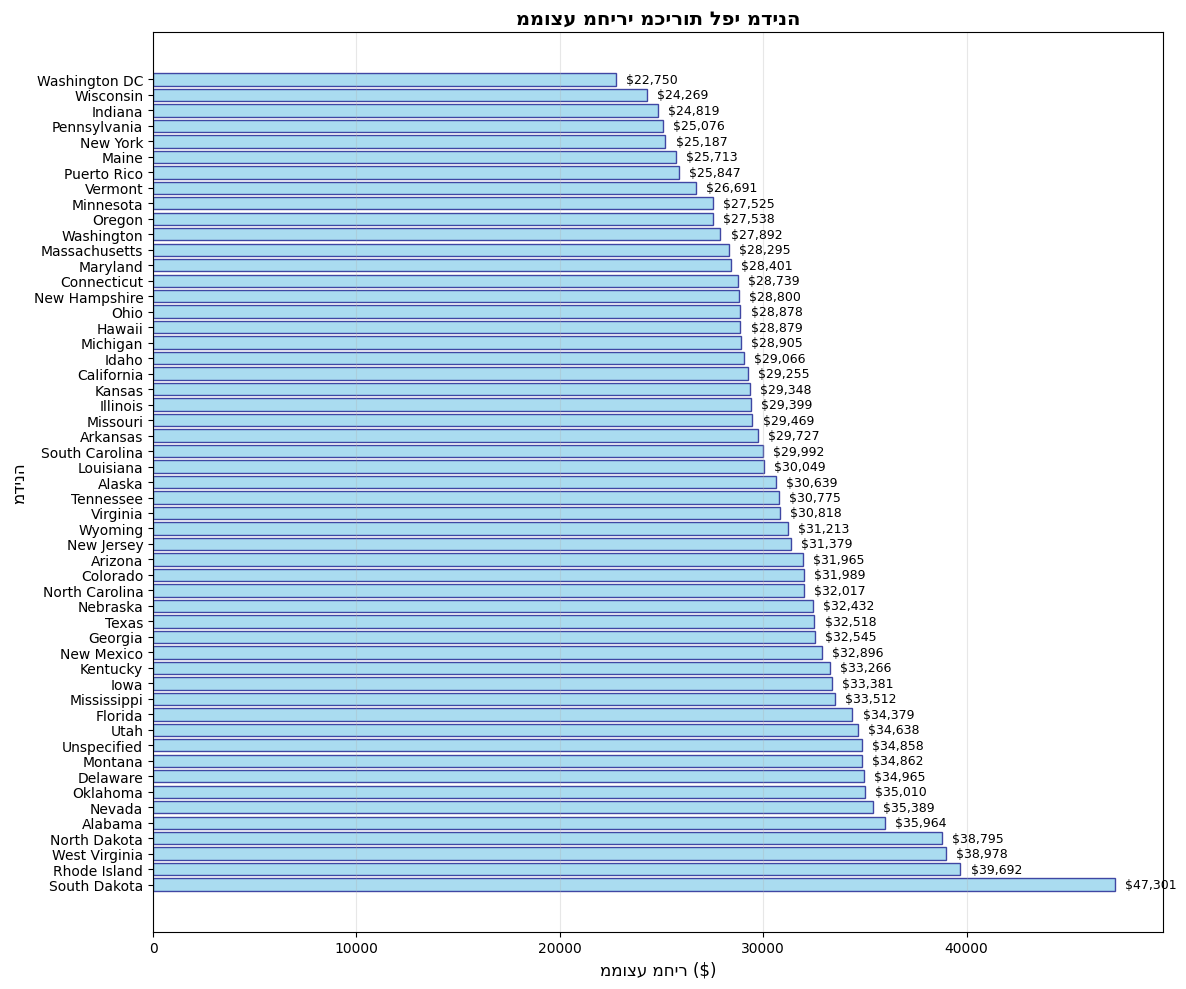

In [6]:
price_summary = df_train_trunc.groupby('state')['SalePrice'].agg(['mean', 'count']).reset_index()
price_summary.columns = ['מדינה', 'ממוצע_מחיר', 'מספר_מכירות']
price_summary['ממוצע_מחיר'] = price_summary['ממוצע_מחיר'].round(0)
price_summary = price_summary.sort_values('ממוצע_מחיר', ascending=False)

plt.figure(figsize=(12, 10))

bars = plt.barh(price_summary['מדינה'], price_summary['ממוצע_מחיר'],
                color='skyblue', edgecolor='navy', alpha=0.7)

plt.xlabel('ממוצע מחיר ($)', fontsize=12)
plt.ylabel('מדינה', fontsize=12)
plt.title('ממוצע מחירי מכירות לפי מדינה', fontsize=14, fontweight='bold')

# הוספת ערכים על העמודות
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 500, bar.get_y() + bar.get_height()/2,
             f'${width:,.0f}', ha='left', va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()